In [1]:
#libraries
import cv2
import os
import albumentations as alb
import tensorflow as tf
import json
from matplotlib import pyplot as plt
import numpy as np

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D 
from tensorflow.keras.applications import VGG16

In [2]:
#load base image and create a pipline off them

image = tf.data.Dataset.list_files('data\\images\\*.jpg')
image.as_numpy_iterator().next()
def load_img(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img
image = image.map(load_img)

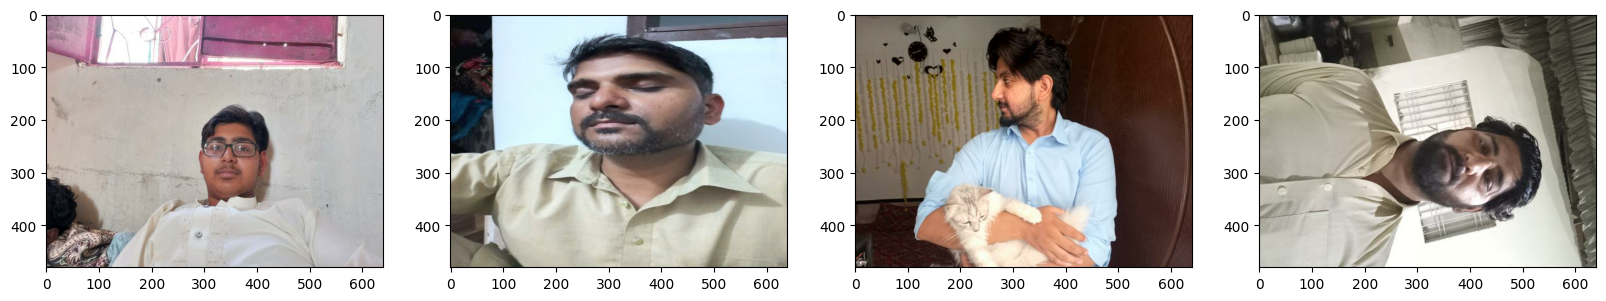

In [3]:
#display using matplot lib
gen_img = image.batch(4).as_numpy_iterator()
plot_images = gen_img.next()
fig , ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(plot_images):
    ax[idx].imshow(img)
plt.show()

In [4]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)    
            
            

In [30]:

    #take images and labels from base folder and annotates them and create their labels
    albumentate = alb.Compose([alb.RandomCrop(width=450, height=450),
                           alb.HorizontalFlip(p=0.5),
                           alb.RandomBrightnessContrast(p=0.2),
                           alb.RandomGamma(p=0.2),
                           alb.RGBShift(p=0.2),
                           alb.VerticalFlip(p=0.5)],
                          bbox_params=alb.BboxParams(format='albumentations',
                                                     label_fields=['class_labels']))
    for partition in ['train','test','val']:
        for image in os.listdir(os.path.join('data', partition, 'images')):
            img = cv2.imread(os.path.join('data', partition, 'images', image))
        
            coords = [0,0,0.00001,0.00001]
        
            label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    label = json.load(f)
                    coords[0] = label['shapes'][0]['points'][0][0] 
                    coords[1]= label['shapes'][0]['points'][0][1] 
                    coords[2] = label['shapes'][0]['points'][1][0] 
                    coords[3] = label['shapes'][0]['points'][1][1] 
                    coords = list(np.divide(coords, [640,480,640,480]))
            try:
                for x in range(120):
                    augmented = albumentate(image=img, bboxes=[coords], class_labels=['face'])
                    cv2.imwrite(os.path.join('adata', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])
                    annotation = {} 
                    annotation['image'] = image 
                    if os.path.exists(label_path):
       
    
    if len(augmented['bboxes']) == 0:
                            annotation['bbox'] = [0,0,0,0]
                            annotation['class'] = 0 
                        else:
                            annotation['bbox'] = augmented['bboxes'][0]
                            annotation['class'] = 1 
                    else:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    with open(os.path.join('adata', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                        json.dump(annotation, f)
            except Exception as e:
                print(e)

In [5]:
#creates image pipline of all
train_img = tf.data.Dataset.list_files('adata\\train\\images\\*.jpg', shuffle=False)
train_img = train_img.map(load_img)
train_img = train_img.map(lambda x: tf.image.resize(x, (120,120)))
train_img = train_img.map(lambda x: x/255)

test_img = tf.data.Dataset.list_files('adata\\test\\images\\*.jpg', shuffle=False)
test_img = test_img.map(load_img)
test_img = test_img.map(lambda x: tf.image.resize(x,(120,120)))
test_img = test_img.map(lambda x:x/255)

valimg = tf.data.Dataset.list_files('adata\\val\\images\\*.jpg', shuffle=False)
valimg = valimg.map(load_img)
valimg = valimg.map(lambda x: tf.image.resize(x,(120,120)))
valimg = valimg.map(lambda x:x/255)

In [6]:
train_img.as_numpy_iterator().next()

array([[[0.13357843, 0.3071691 , 0.4540441 ],
        [0.17794117, 0.33137256, 0.48284313],
        [0.18112744, 0.3608456 , 0.490625  ],
        ...,
        [0.05459559, 0.07469363, 0.10851716],
        [0.06029412, 0.08039216, 0.11421569],
        [0.04797794, 0.06776961, 0.09515931]],

       [[0.07438725, 0.24693628, 0.39987746],
        [0.05006127, 0.21574755, 0.37028188],
        [0.0278799 , 0.21611519, 0.35729167],
        ...,
        [0.03829657, 0.07359069, 0.09319853],
        [0.03480392, 0.07009804, 0.08970588],
        [0.05128676, 0.0841299 , 0.09883578]],

       [[0.13137256, 0.2998162 , 0.43762255],
        [0.11335784, 0.27904412, 0.42757353],
        [0.09295343, 0.2733456 , 0.41495097],
        ...,
        [0.03529412, 0.0627451 , 0.08627451],
        [0.04270833, 0.07015932, 0.09368873],
        [0.03921569, 0.06666667, 0.09019608]],

       ...,

       [[0.04883578, 0.11096814, 0.16194853],
        [0.0598652 , 0.13566177, 0.190625  ],
        [0.07579657, 0

In [7]:
#label loading function(loads class and boundryboxes
def load_label(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [8]:
#load label using load_label function

train_label = tf.data.Dataset.list_files('adata\\train\\labels\\*.json', shuffle=False)
train_label = train_label.map(lambda x: tf.py_function(load_label, [x], [tf.uint8, tf.float16]))

test_label = tf.data.Dataset.list_files('adata\\test\\labels\\*.json', shuffle=False)
test_label = test_label.map(lambda x: tf.py_function(load_label, [x], [tf.uint8,tf.float16]))

val_label = tf.data.Dataset.list_files('adata\\val\\labels\\*.json', shuffle=False)
val_label = val_label.map(lambda x: tf.py_function(load_label, [x], [tf.uint8,tf.float16]))

In [9]:

train_label.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

In [10]:

#combine image with labels and create batches
train= tf.data.Dataset.zip((train_img, train_label))
train = train.shuffle(800)
train = train.batch(8)
train = train.prefetch(4)

test = tf.data.Dataset.zip((test_img, test_label))
test = test.shuffle(300)
test = test.batch(8)
test = test.prefetch(4)

val = tf.data.Dataset.zip((valimg, val_label))
val = val.shuffle(400)
val = val.batch(8)
val = val.prefetch(4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


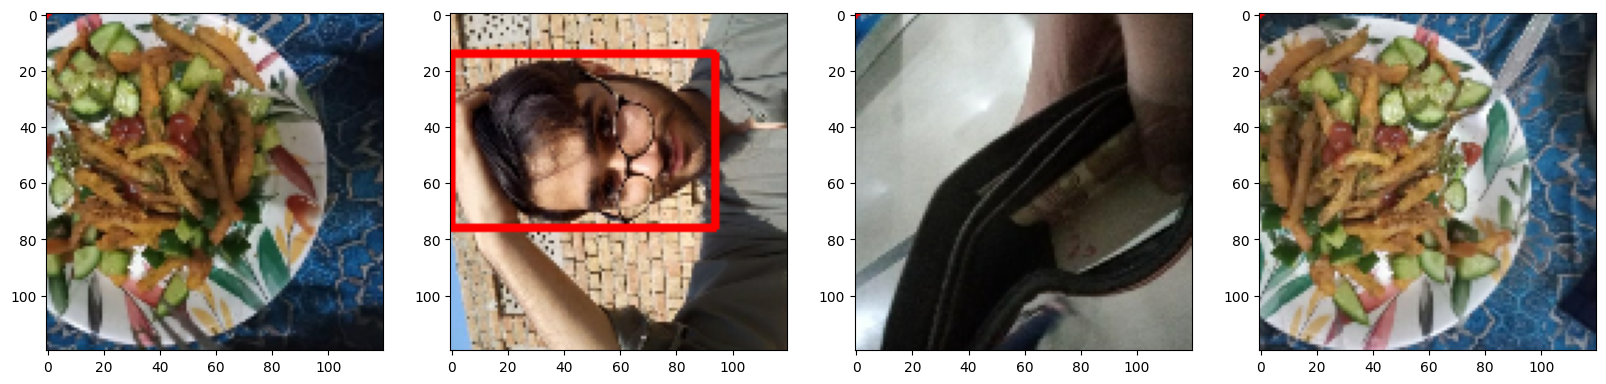

In [11]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [12]:
#build model function

def build_model():
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)
    
    f1 = GlobalMaxPooling2D()(vgg)
    
    clss1 = Dense(2048, activation = 'relu')(f1)
    clss2 = Dense(1, activation = 'sigmoid')(clss1)
    
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation = 'relu')(f2)
    regress2 = Dense(4, activation = 'sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer,outputs=[clss2, regress2])
    return facetracker

In [13]:

#testing
facetracker = build_model()
facetracker.summary()
x,y = train.as_numpy_iterator().next()
classes, coords = facetracker.predict(x)
classes, coords

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_1[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

(array([[0.48668304],
        [0.34380218],
        [0.4128262 ],
        [0.40927315],
        [0.3809005 ],
        [0.3570474 ],
        [0.40402302],
        [0.39433342]], dtype=float32),
 array([[0.5283948 , 0.49423093, 0.5032338 , 0.361185  ],
        [0.51422995, 0.3638374 , 0.5538811 , 0.4157964 ],
        [0.5666768 , 0.48757434, 0.5724691 , 0.41906485],
        [0.61045843, 0.46474463, 0.62289596, 0.44800937],
        [0.5885025 , 0.4873141 , 0.5628949 , 0.43524364],
        [0.5959668 , 0.50105035, 0.45299086, 0.39471674],
        [0.5817202 , 0.48416084, 0.5150277 , 0.38991538],
        [0.6437885 , 0.47637838, 0.6535676 , 0.34505036]], dtype=float32))

In [14]:
x.shape, y[0], y[1]


((8, 120, 120, 3),
 array([[1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0]], dtype=uint8),
 array([[0.3823, 0.516 , 0.754 , 0.842 ],
        [0.    , 0.3027, 0.73  , 0.8213],
        [0.4387, 0.336 , 1.    , 0.8545],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ]], dtype=float16))

In [16]:
#learn decay rate(0.000175

batches_per_epoch = len(train)
lr_decay = (1./0.9179-1)/batches_per_epoch
lr_decay

0.00017036817995528083

In [17]:
#optimizer for learning(AdamW )
opt= tf.keras.optimizers.AdamW(learning_rate=0.0001,weight_decay=lr_decay)

In [18]:
#regression model localization loss function

def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [19]:
#loading loss functions(binarycrossentropy for 
#two classes and custom loss function for regress(bboxes
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [20]:
#test
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.1040525>

In [21]:

classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.642389>

In [22]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.1040525>

In [23]:



#creating class to load model train val and test the model

class FaceTracker(Model): 
    def __init__(self, facetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [24]:
#creating
model = FaceTracker(facetracker)

In [25]:
model.compile(opt, classloss,regressloss)

In [26]:
#log directory
logdir = 'logs'

In [27]:
tboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [28]:
#training and valiating
hist = model.fit(train.take(100), epochs=10, validation_data = val,callbacks=[tboard_callback])

Epoch 1/10
100/100 [==============================] - 432s 4s/step - total_loss: 0.5820 - class_loss: 0.1287 - regress_loss: 0.5176 - val_total_loss: 2.1217 - val_class_loss: 0.3097 - val_regress_loss: 1.9668
Epoch 2/10
100/100 [==============================] - 420s 4s/step - total_loss: 0.1442 - class_loss: 0.0135 - regress_loss: 0.1374 - val_total_loss: 2.6885 - val_class_loss: 0.0194 - val_regress_loss: 2.6788
Epoch 3/10
100/100 [==============================] - 416s 4s/step - total_loss: 0.0751 - class_loss: 0.0141 - regress_loss: 0.0680 - val_total_loss: 2.4951 - val_class_loss: 0.1123 - val_regress_loss: 2.4390
Epoch 4/10
100/100 [==============================] - 415s 4s/step - total_loss: 0.0600 - class_loss: 0.0093 - regress_loss: 0.0553 - val_total_loss: 4.8693 - val_class_loss: 2.1575 - val_regress_loss: 3.7906
Epoch 5/10
100/100 [==============================] - 416s 4s/step - total_loss: 0.0173 - class_loss: 2.5481e-04 - regress_loss: 0.0172 - val_total_loss: 1.0993 - v

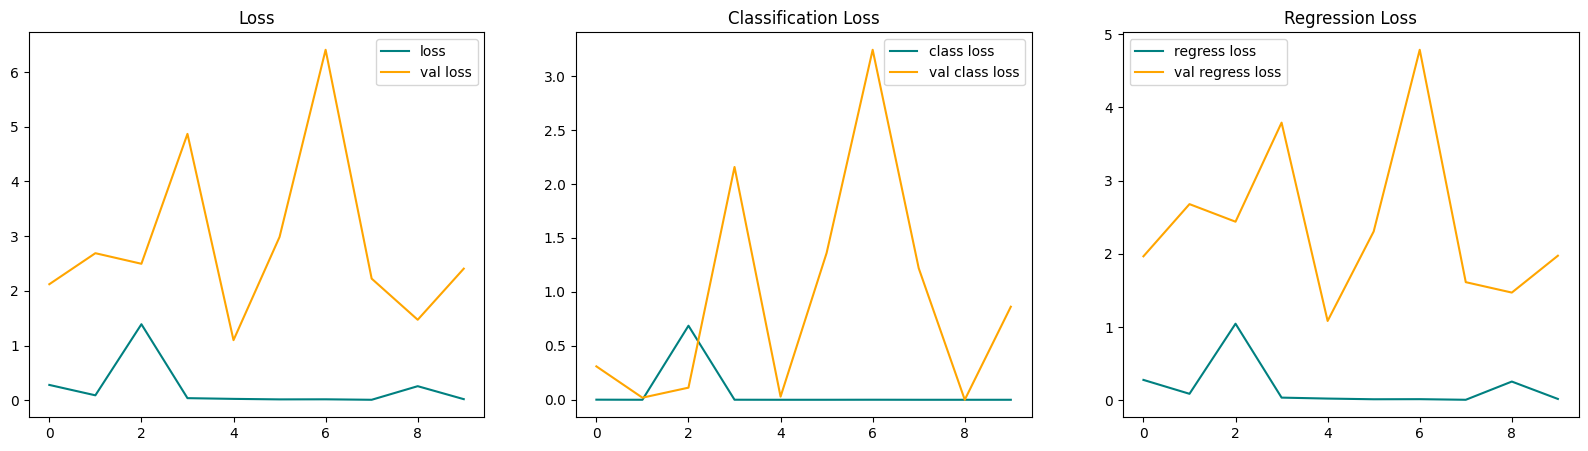

In [29]:
#results in graph form
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

1/1 [==============================] - 1s 812ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


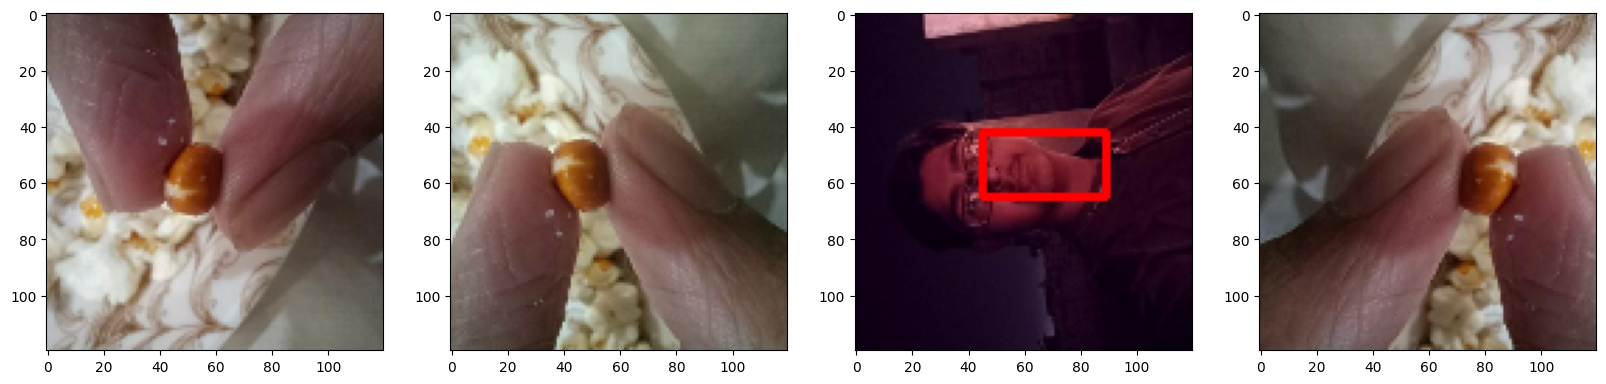

In [41]:
#testing 
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.5:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [1]:
#saving model as .keras file
from tensorflow.keras.models import load_model
facetracker.save('facetracker.keras')


NameError: name 'facetracker' is not defined

In [2]:
facetracker = load_model('facetracker.keras')
cap = cv2.VideoCapture('a.mp4')
size = (450,450)
while cap.isOpened():
    _ , frame = cap.read()
    try:
        frame = cv2.resize(frame, size)
    except Exception as e:
        print(e)
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

NameError: name 'cv2' is not defined

In [ ]:
from tensorflow.keras.models import load_model
facetracker = load_model('facetracker.keras')

